In [1]:
import pandas as pd
import numpy as np
import random
import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

#критерии проверки статистических гипотез
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [6]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [7]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [8]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [9]:
def balance_df_by_target(df, target_name, method='smote'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [10]:
#input
TRAIN_DATASET_PATH = '../input/ds803/course_project_train.csv'
TEST_DATASET_PATH = '../input/ds803/course_project_test.csv'

# output
MODEL_FILE_PATH = '../model.pkl'

In [11]:
train_data = pd.read_csv(TRAIN_DATASET_PATH)
test_data = pd.read_csv(TEST_DATASET_PATH)

In [12]:
train_data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [13]:
train_data.shape

(7500, 17)

In [14]:
#посмотрим на типы данных
train_data.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

# 1. Первичный анализ задачи

In [15]:
#посомтрим на основные статистики по признакам
train_data.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Вывод:
- выбросы в признаках Annual Income, Tax Liens, Years of Credit History, Maximum Open Credit, Number of Credit Problems, Months since last delinquent, Bankruptcies,Current Loan Amount, Current Credit Balance, Monthly Debt.
- пропуски в признаках Annual Income, Months since last delinquent, Bankruptcies, Credit Score 

In [16]:
train_data.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

Выделим вещественные и категориельные признаки в отделные переменные

In [17]:
target_name = 'Credit Default'

base_feature_names = train_data.columns.drop([target_name]).tolist()

cat_feature_names = train_data.select_dtypes(include='object').columns.tolist()

num_feature_names = train_data.columns.drop([target_name] + cat_feature_names).tolist()

# base_feature_names = ['Home Ownership', 'Annual Income', 'Tax Liens', 'Years in current job',
#                       'Number of Open Accounts', 'Years of Credit History',
#                       'Maximum Open Credit', 'Number of Credit Problems',
#                       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
#                       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
#                       'Credit Score']

# num_feature_names = ['Annual Income', 'Tax Liens',
#                      'Number of Open Accounts', 'Years of Credit History',
#                      'Maximum Open Credit', 'Number of Credit Problems',
#                      'Months since last delinquent', 'Bankruptcies',
#                      'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
#                      'Credit Score']

# cat_feature_names = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [18]:
#посомтрим на баланс классов у целевой переменной
train_data['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Вывод: выборка не сбалансированна, следует равномерно разделить объекты при делении на обучающее и тестовое множество

In [19]:
# Посмотрим на количество пропусков по всем датасете
train_data.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [20]:
for cat_colname in cat_feature_names:
    print(str(cat_colname) + '\n\n' + str(train_data[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

## 1.1 Корреляция целевой переменной с базовыми признаками

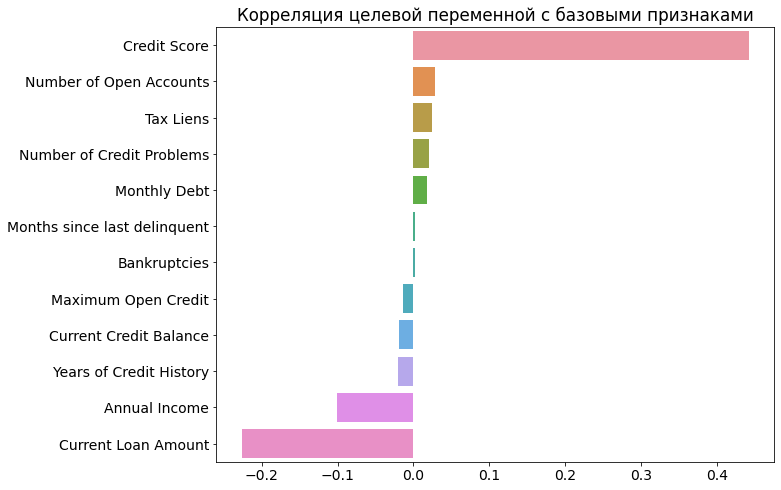

In [21]:
corr_with_target = train_data[base_feature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корреляция целевой переменной с базовыми признаками')
plt.show()

По гистограмме расположенной выше, можно сделать вывод, что на целевую переменную в большей степени оказывают значение признаки Credit Score, Annual Income, Current Loan Amount (кредитный рейтинг, годовой доход, текущая сумма кредита). Так же можно отметить, что признаки Months since last delinquent', 'Bankruptcies' практически не влияют на целевую переменную и может быть их тоит удалить припостроении модели.

## 1.2 Матрица корреляций признаков

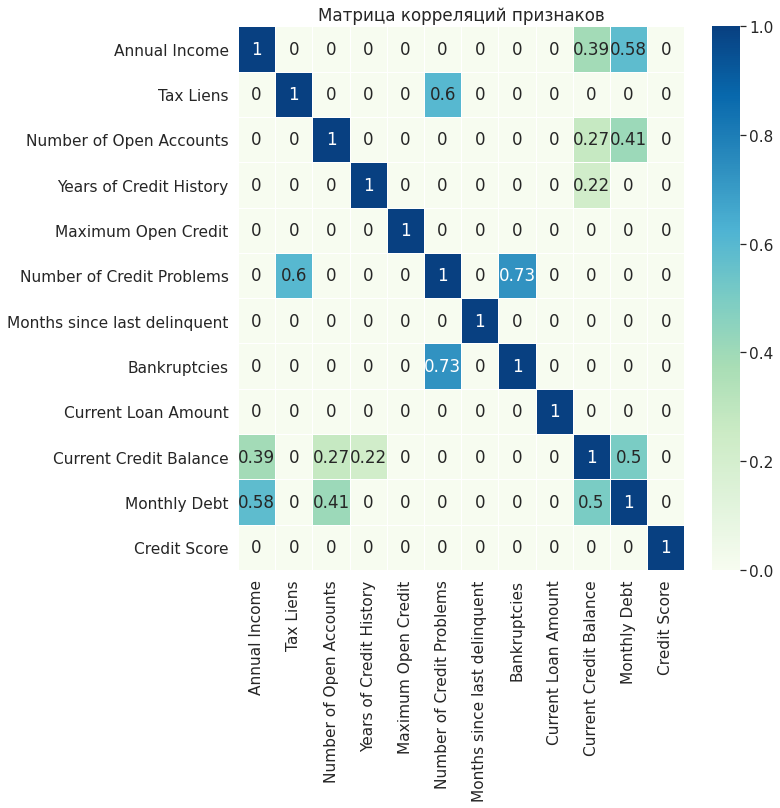

In [22]:
plt.figure(figsize = (10,10))

sns.set(font_scale=1.4)

corr_matrix = train_data[base_feature_names].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Матрица корреляций признаков')
plt.show()

Следующие пары признаков имеют значимую корреляцию между собой:
* Bankruptcies и Number of Credit Problems (банкротства/количество проблем с кредитом)
* Tax Lines и Number of Credit Problems (налоговые обременения/количество проблем с кредитом)
* Annual Income и Monthly Debt (годовой доход/ежемесячный долг) 


# 2. Работа с признаками

## 2.1  Категориальные признаки

In [23]:
cat_feature_names

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

### 2.1.1 Признак Home Ownership

In [24]:
train_data['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

объеденим значения признака Home Mortgage и Have Mortgage в одно значение: Home Mortgage

In [25]:
train_data.loc[train_data['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = "Home Mortgage"

In [26]:
# проверка
train_data['Home Ownership'].value_counts()

Home Mortgage    3649
Rent             3204
Own Home          647
Name: Home Ownership, dtype: int64

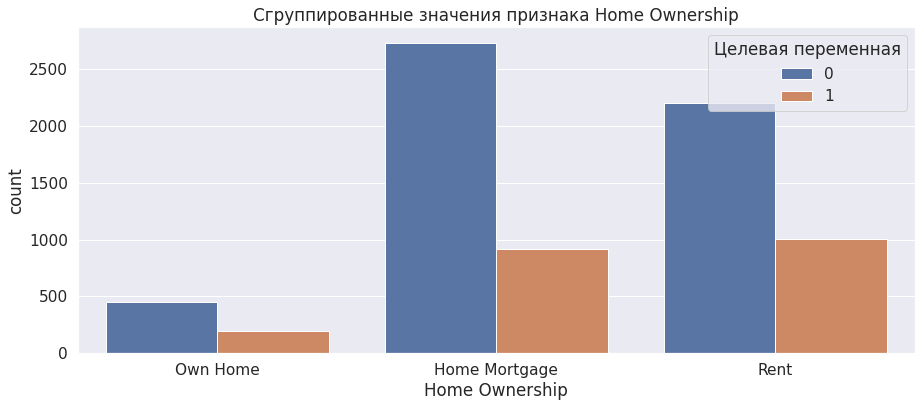

In [27]:
plt.figure(figsize=(15, 6))

sns.countplot(x="Home Ownership", hue=target_name, data=train_data)
plt.title('Сгруппированные значения признака Home Ownership')
plt.legend(title='Целевая переменная', loc='upper right')

plt.show()

### 2.1.2 Признак Years in current job

In [28]:
train_data['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

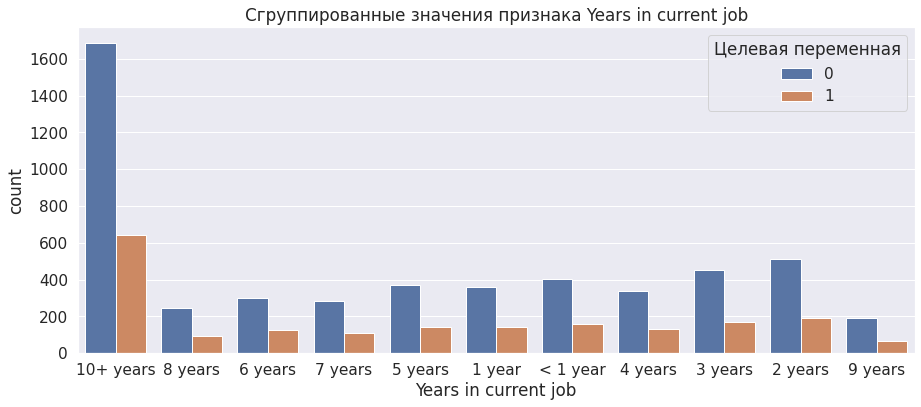

In [29]:
plt.figure(figsize=(15, 6))

sns.countplot(x="Years in current job", hue=target_name, data=train_data)
plt.title('Сгруппированные значения признака Years in current job')
plt.legend(title='Целевая переменная', loc='upper right')

plt.show()

In [30]:
train_data['Years in current job error'] = 0
train_data.loc[train_data['Years in current job'].isna(), 'Years in current job error'] = 1

In [31]:
train_data['Years in current job'].mode()[0]

'10+ years'

In [32]:
train_data.loc[train_data['Years in current job'].isna(), 'Years in current job'] = train_data['Years in current job'].mode()[0]

In [33]:
train_data['Years in current job'].value_counts()

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

### 2.1.3 Признак Purpose (цель кредита)

In [34]:
train_data.loc[train_data['Purpose'] == 'renewable energy', 'Purpose'] = 'other'

In [35]:
train_data['Purpose'].value_counts()

debt consolidation      5944
other                    667
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
Name: Purpose, dtype: int64

In [36]:
values_purpose = ['debt consolidation','other','home improvements','business loan','buy a car','medical bills',\
                       'major purchase','take a trip','buy house','small business','wedding', 'moving',\
                       'educational expenses','vacation','renewable energy']
train_data['Id'] = train_data.index
purpose_target = train_data.loc[train_data['Purpose'].isin(values_purpose),\
                                        ['Id', 'Purpose', 'Credit Default']]
purpose_target

,Id,Purpose,Credit Default
0,0,debt consolidation,0
1,1,debt consolidation,1
2,2,debt consolidation,0
3,3,debt consolidation,0
4,4,debt consolidation,0
...,...,...,...
7495,7495,other,0
7496,7496,debt consolidation,1
7497,7497,buy a car,0
7498,7498,debt consolidation,0


In [37]:
table_purpose = purpose_target.pivot_table(values='Id', index='Purpose', \
                                                         columns='Credit Default', aggfunc='count')
table_purpose

Credit Default,0,1
Purpose,,
business loan,74,55
buy a car,72,24
buy house,25,9
debt consolidation,4290,1654
educational expenses,9,1
home improvements,304,108
major purchase,31,9
medical bills,49,22
moving,9,2


In [38]:
#посомтрим на соотношение значений и разделим на группы 
(table_purpose[1]/table_purpose[0]).sort_values()

Purpose
educational expenses    0.111111
moving                  0.222222
major purchase          0.290323
buy a car               0.333333
vacation                0.333333
home improvements       0.355263
buy house               0.360000
wedding                 0.363636
take a trip             0.370370
debt consolidation      0.385548
other                   0.425214
medical bills           0.448980
business loan           0.743243
small business          1.166667
dtype: float64

In [39]:
#сгруппируем признаки следующим образом и будем проверять критерий Хи-квадрат Пирсона с альфа = 0,05:
values_purpose = [['moving','major purchase','buy a car','vacation','home improvements','buy house'],
                  ['wedding','take a trip','debt consolidation'],
                  ['other','medical bills',],
                  ['business loan', 'small business']]

In [40]:
def union_check_purpose(X):
    result_list = []
    i=0
    for i in range(len(values_purpose)):
        X['Id'] = X.index
        purpose_target = X.loc[X['Purpose'].isin(values_purpose[i]), \
                                   ['Id', 'Purpose', 'Credit Default']]
        table_purpose = purpose_target.pivot_table(values='Id', index='Purpose', \
                                                         columns='Credit Default', aggfunc='count')
        chi2, p, _, _ = chi2_contingency(table_purpose)
#         result_list.append(p)
        if p > 0.05:
            result_list.append(f'можно объединять образец № {i}') #категории можно объединить
        else:
            result_list.append(f'нельзя объединять образец № {i}') #категории нельзя объединять
    return result_list

In [41]:
result_union_check_purpose = union_check_purpose(train_data)
result_union_check_purpose

['можно объединять образец № 0',
 'можно объединять образец № 1',
 'можно объединять образец № 2',
 'можно объединять образец № 3']

In [42]:
def change_Purpose(X):
    X.loc[X['Purpose'].isin(['moving','major purchase','buy a car','vacation','home improvements','buy house']),'Purpose'] = 'value_1'
    X.loc[X['Purpose'].isin(['wedding','take a trip','debt consolidation']),'Purpose'] = 'value_2'
    X.loc[X['Purpose'].isin(['other','medical bills',]),'Purpose'] = 'value_3'
    X.loc[X['Purpose'].isin(['business loan', 'small business']),'Purpose'] = 'value_4'
    X.loc[X['Purpose'] == 'educational expenses', 'Purpose'] = 'value_5'
    return X

train_data = change_Purpose(train_data)

In [43]:
train_data['Purpose'].value_counts()

value_2    5996
value_3     738
value_1     601
value_4     155
value_5      10
Name: Purpose, dtype: int64

### 2.1.4 Признак Term

In [44]:
train_data['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

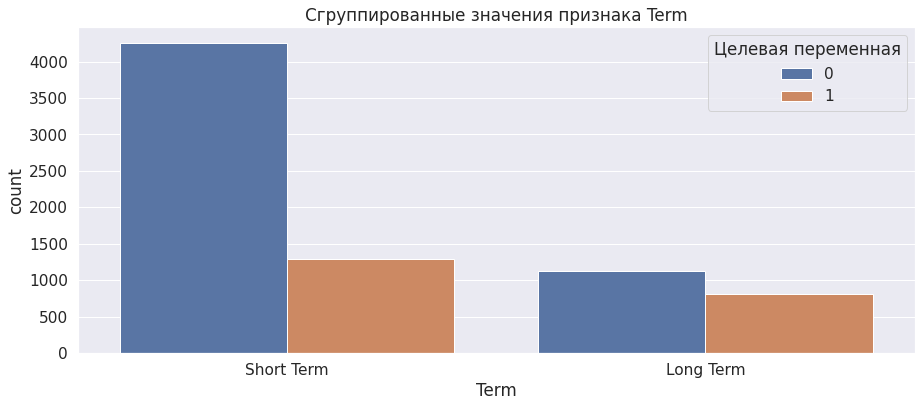

In [45]:
plt.figure(figsize=(15, 6))

sns.countplot(x="Term", hue=target_name, data=train_data)
plt.title('Сгруппированные значения признака Term')
plt.legend(title='Целевая переменная', loc='upper right')

plt.show()

С данным признаком ничего делать не будем

### Все категориальные признаки закодируем в дамми-переменные

In [46]:
for cat_colname in cat_feature_names:
    train_data = pd.concat([train_data, pd.get_dummies(train_data[cat_colname], prefix=cat_colname)], axis=1)

## 2.2 Вещественные признаки

In [47]:
train_data.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Purpose_value_1,Purpose_value_2,Purpose_value_3,Purpose_value_4,Purpose_value_5,Term_Long Term,Term_Short Term
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,...,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,...,0.045200,0.034533,0.075067,0.080133,0.799467,0.098400,0.020667,0.001333,0.259200,0.740800
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,...,0.207756,0.182607,0.263516,0.271518,0.400426,0.297875,0.142275,0.036493,0.438225,0.438225
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Выводы:
* выбросы в признаках Annual Income, Maximum Open Credit
* пропуски в признаках Months since last delinquent, Annual Income, CreditScore.


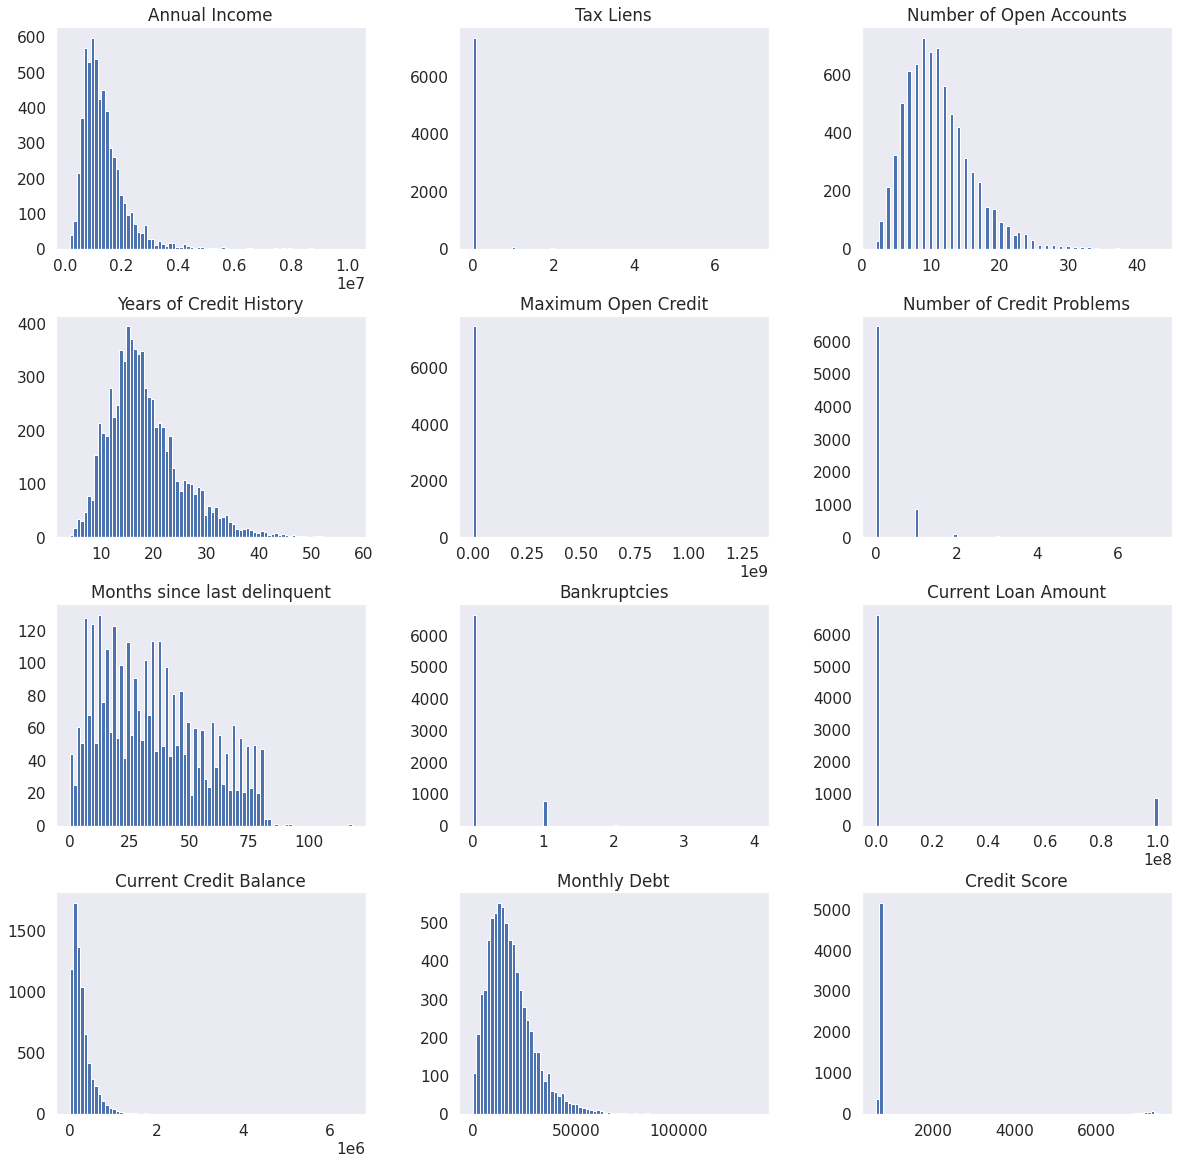

In [48]:
train_data[num_feature_names].hist(figsize=(20, 20), bins=80, grid=False);

In [49]:
#количество пропусков в признаках
train_data[base_feature_names].isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
dtype: int64

Пропуски есть в признаках: Annual Income(годовой доход), Months since last delinquent(количество месяцев с последней просрочки платежа), Credit Score (Кредитный рейтинг), Years in current job(количество лет кредитной истории). В признаке Months since last delinquent отсутствуют больше половины данных

### 2.2.1 Признак Annual Income (годовой доход)

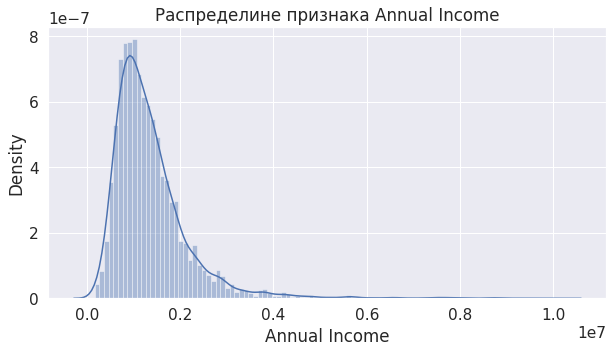

In [50]:
plt.figure(figsize = (10, 5))

sns.distplot(train_data['Annual Income'], bins=100)
plt.title('Распределине признака Annual Income')
plt.show()

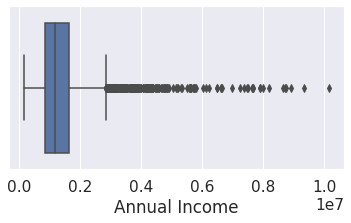

In [51]:
# Посмотрим на значения, которые могут быть выбросами
plt.figure(figsize=(6, 3))

sns.boxplot(train_data['Annual Income'], whis=1.5)

plt.xlabel('Annual Income')
plt.show()

In [52]:
#Посмотрим на годовой доход > 8000000:
train_data[train_data['Annual Income'] > 8000000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Purpose_value_1,Purpose_value_2,Purpose_value_3,Purpose_value_4,Purpose_value_5,Term_Long Term,Term_Short Term
1025,Rent,8923844.0,3 years,0.0,15.0,17.2,1452000.0,0.0,NaN,0.0,...,0,0,0,0,1,0,0,0,0,1
1984,Home Mortgage,8758449.0,10+ years,0.0,10.0,20.6,0.0,0.0,NaN,0.0,...,0,0,0,1,0,0,0,0,0,1
2200,Rent,9338880.0,10+ years,0.0,7.0,7.3,1092608.0,0.0,NaN,0.0,...,0,0,0,0,0,0,1,0,0,1
2474,Home Mortgage,8633790.0,2 years,0.0,13.0,15.6,1091200.0,0.0,36.0,0.0,...,0,0,0,0,1,0,0,0,1,0
4491,Home Mortgage,8200229.0,2 years,0.0,11.0,16.7,333630.0,0.0,29.0,0.0,...,0,0,0,0,1,0,0,0,0,1
5396,Home Mortgage,8710740.0,2 years,2.0,15.0,16.5,3162896.0,2.0,NaN,0.0,...,0,0,0,0,1,0,0,0,0,1
6472,Rent,10149344.0,5 years,0.0,10.0,17.5,270380.0,0.0,22.0,0.0,...,0,0,0,0,1,0,0,0,0,1


Выдвинутые гипотезы:
- сомнительными являются значения признака > 8.000.000 

Сомнительные значения будем обрабатывать. Создадим дополнительный признак Annual Income_error, в котором будем помечать сомнительные значения (0 - корректные данные; 1 - некорректные данные).

In [53]:
train_data['Annual_Income_error'] = 0
train_data.loc[(train_data['Annual Income'].isna()) | \
               (train_data['Annual Income'] > 8000000), 'Annual_Income_error'] = 1

Обработка значений признака Annual Income, где годовой доход > 8 000 000 (будем заполнять медианой):

In [54]:
train_data.loc[(train_data['Annual Income'].isna()) | \
               (train_data['Annual Income'] > 8000000), 'Annual Income'] = train_data['Annual Income'].median()

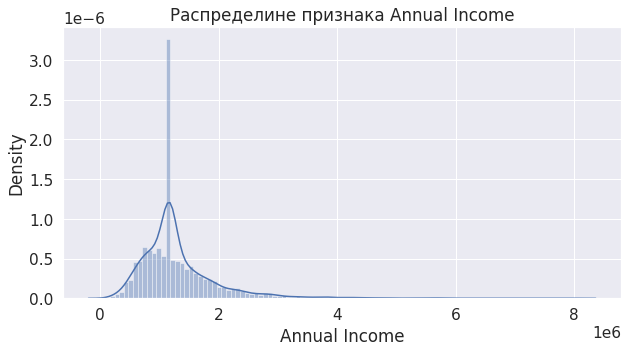

In [55]:
# Посмотри на график распределения признака Annual Income после обработки некорректных значений
plt.figure(figsize = (10, 5))

sns.distplot(train_data['Annual Income'], bins=100)
plt.title('Распределине признака Annual Income')
plt.show()

### 2.2.2 Признак Tax Liens (налоговые обременения)

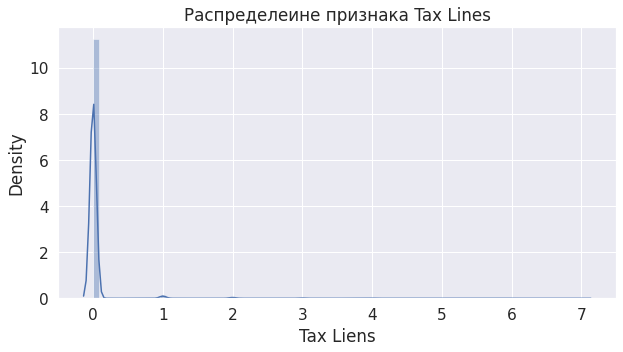

In [56]:
# Распределеине значений признакак Tax Lines
plt.figure(figsize = (10, 5))

sns.distplot(train_data['Tax Liens'], bins=80)

plt.title("Распределеине признака Tax Lines")

plt.show()

In [57]:
#посмотрим на значения признака Tax Liens
train_data['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

пока никак не огриничиваю данный признак и не вношу изменений

### 2.2.3 Признак Number of Open Accounts (количество открытых счетов)

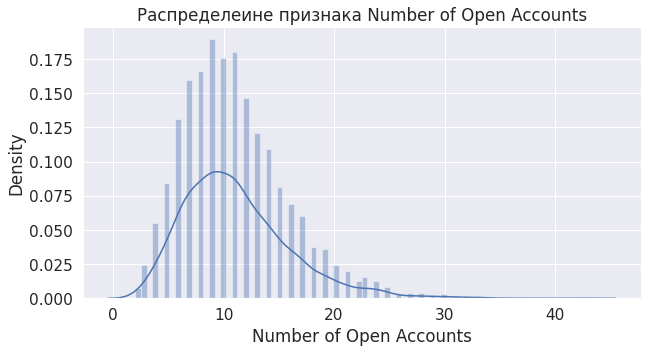

In [58]:
# Распределеине значений признакак Number of Open Accounts
plt.figure(figsize = (10, 5))

sns.distplot(train_data['Number of Open Accounts'], bins=80)
plt.title("Распределеине признака Number of Open Accounts")
plt.show()

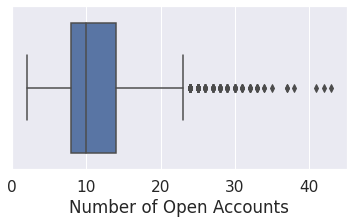

In [59]:
# Посомтрим на знаения, которые могут быть выбросами
plt.figure(figsize=(6, 3))

sns.boxplot(train_data['Number of Open Accounts'], whis=1.5)

plt.xlabel('Number of Open Accounts')
plt.show()

Из графиков показанных выше, можно сделать вывод что есть значения признака Number of Open Accounts, которые являются выбросами. Будем обрабатывать данные выбросы. Создадим дополнительный признак Number_of_open_accounts_error, в котором будем помечать является значение выбросом или нет: 0 - условие выполняется, 1 - не выполяется.

In [60]:
#Значения признака Number_of_open_accounts являющихся выбросами:
train_data[train_data['Number of Open Accounts'] > 22]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Years in current job_9 years,Years in current job_< 1 year,Purpose_value_1,Purpose_value_2,Purpose_value_3,Purpose_value_4,Purpose_value_5,Term_Long Term,Term_Short Term,Annual_Income_error
168,Home Mortgage,2379522.0,2 years,0.0,23.0,17.8,1267530.0,0.0,37.0,0.0,...,0,0,0,1,0,0,0,0,1,0
187,Home Mortgage,1168386.0,3 years,0.0,24.0,20.5,2940916.0,0.0,NaN,0.0,...,0,0,0,1,0,0,0,1,0,1
190,Rent,1857554.0,7 years,0.0,24.0,19.7,707630.0,0.0,NaN,0.0,...,0,0,0,1,0,0,0,0,1,0
191,Rent,479940.0,5 years,0.0,23.0,10.5,450626.0,0.0,NaN,0.0,...,0,0,0,1,0,0,0,0,1,0
276,Home Mortgage,2073261.0,10+ years,0.0,25.0,42.1,1584308.0,0.0,NaN,0.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7247,Home Mortgage,2106302.0,1 year,0.0,24.0,16.8,858132.0,0.0,NaN,0.0,...,0,0,0,1,0,0,0,0,1,0
7265,Home Mortgage,1151590.0,4 years,0.0,24.0,29.0,994752.0,1.0,NaN,1.0,...,0,0,0,1,0,0,0,0,1,0
7277,Home Mortgage,1791472.0,10+ years,0.0,23.0,26.7,1111572.0,0.0,59.0,0.0,...,0,0,1,0,0,0,0,1,0,0
7292,Home Mortgage,1414892.0,8 years,0.0,28.0,15.2,1240426.0,0.0,NaN,0.0,...,0,0,0,1,0,0,0,0,1,0


In [61]:
# создаем дополнительный признак Number_of_open_accounts_error, сигнализирующий об ошибке
train_data['Number_of_open_accounts_error'] = 0

In [62]:
train_data.loc[(train_data['Number of Open Accounts'].isna()) | \
               (train_data['Number of Open Accounts'] > 22), 'Number_of_open_accounts_error'] = 1

In [63]:
train_data.loc[(train_data['Number of Open Accounts'].isna()) | \
               (train_data['Number of Open Accounts'] > 22), \
               'Number of Open Accounts'] = train_data['Number of Open Accounts'].median()

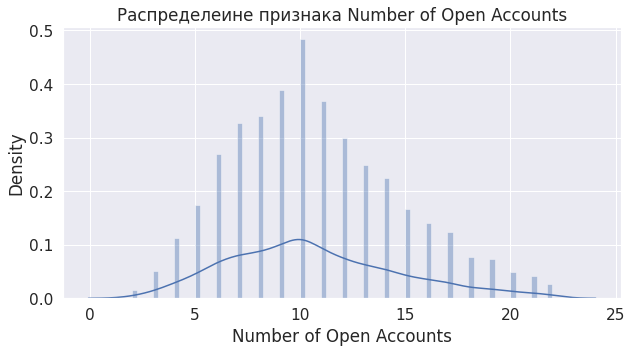

In [64]:
# Распределеине значений признакак Number of Open Accounts после обработки выбросов
plt.figure(figsize = (10, 5))

sns.distplot(train_data['Number of Open Accounts'], bins=80)
plt.title("Распределеине признака Number of Open Accounts")
plt.show()

### 2.2.4 Признак Years of Credit History (количество лет кредитной истории)

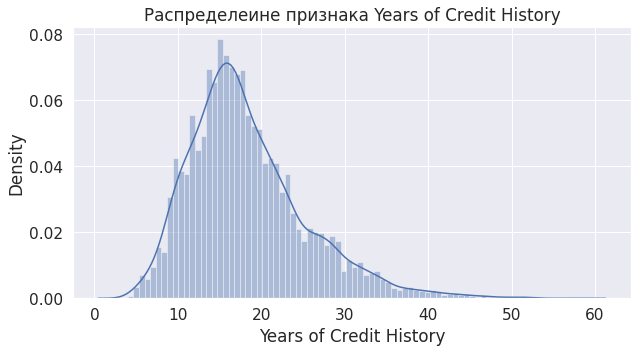

In [65]:
# Распределеине значений признакак Years of Credit History
plt.figure(figsize = (10, 5))

sns.distplot(train_data['Years of Credit History'], bins=80)
plt.title("Распределеине признака Years of Credit History")
plt.show()

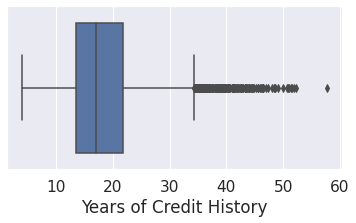

In [66]:
# Посомтрим на знаения, которые могут быть выбросами
plt.figure(figsize=(6, 3))

sns.boxplot(train_data['Years of Credit History'], whis=1.5)

plt.xlabel('Years of Credit History')
plt.show()

По построенным графикам видны выбросы значений рассматриваемого признака Years of Credit History. При анализе будем исходить из следующих гипотез:
- кредиты выдают с 18 лет и до 70 лет на момент окончания кредита, следовательно если даже брать кредит на все возможно время, то максимальное значение признака должно быть 52 года.

Выбросы будем отмечать в новом признаке Years_of_credit_history_error

In [67]:
train_data.loc[train_data['Years of Credit History'].isna() | (train_data['Years of Credit History'] >= 52)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Years in current job_< 1 year,Purpose_value_1,Purpose_value_2,Purpose_value_3,Purpose_value_4,Purpose_value_5,Term_Long Term,Term_Short Term,Annual_Income_error,Number_of_open_accounts_error
247,Home Mortgage,1893426.0,10+ years,0.0,7.0,52.2,711524.0,0.0,NaN,0.0,...,0,0,1,0,0,0,1,0,0,0
476,Home Mortgage,1076768.0,10+ years,0.0,14.0,57.7,432124.0,0.0,24.0,0.0,...,0,0,1,0,0,0,1,0,0,0


In [68]:
# создаем дополнительный признак Years_of_credit_history_error, сигнализирующий об ошибке
train_data['Years_of_credit_history_error'] = 0

In [69]:
#записываем в новый признак информацию 
train_data.loc[(train_data['Years of Credit History'].isna()) | \
               (train_data['Years of Credit History'] >= 52), 'Years_of_credit_history_error'] = 1

In [70]:
# Обработаем выбросы, где нарушаются выдвинутые для признака Years of Credit History гипотезы
train_data.loc[(train_data['Years of Credit History'].isna()) | \
               (train_data['Years of Credit History'] > 52), 'Years of Credit History'] = train_data['Years of Credit History'].median()

### 2.2.5 Признак Maximum Open Credit (наибольший открытый кредит)

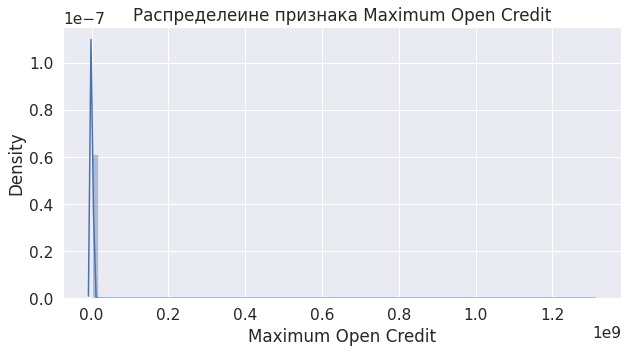

In [71]:
# Распределеине значений признакак Maximum Open Credit
plt.figure(figsize = (10, 5))

sns.distplot(train_data['Maximum Open Credit'], bins=80)
plt.title("Распределеине признака Maximum Open Credit")
plt.show()

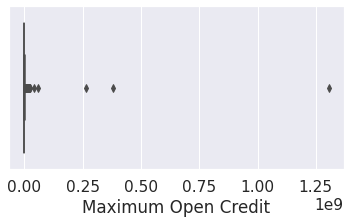

In [72]:
# Посомтрим на знаения, которые могут быть выбросами
plt.figure(figsize=(6, 3))

sns.boxplot(train_data['Maximum Open Credit'], whis=1.5)

plt.xlabel('Maximum Open Credit')
plt.show()

In [73]:
#посомтрим на данные, которые предположительно являются выбросами
train_data[train_data['Maximum Open Credit'] > 250000000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Purpose_value_1,Purpose_value_2,Purpose_value_3,Purpose_value_4,Purpose_value_5,Term_Long Term,Term_Short Term,Annual_Income_error,Number_of_open_accounts_error,Years_of_credit_history_error
44,Home Mortgage,1334256.0,10+ years,0.0,17.0,15.4,3.800523e+08,1.0,35.0,0.0,...,0,1,0,0,0,0,1,0,0,0
617,Home Mortgage,1168386.0,3 years,0.0,13.0,27.5,1.304726e+09,0.0,NaN,0.0,...,0,1,0,0,0,0,1,1,0,0
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,2.655129e+08,0.0,NaN,0.0,...,0,0,1,0,0,0,1,0,0,0


In [74]:
train_data['Maximum_open_credit_error'] = 0

In [75]:
train_data.loc[(train_data['Maximum Open Credit'].isna()) | \
               (train_data['Maximum Open Credit']>250000000), 'Maximum_open_credit_error'] = 1

In [76]:
train_data.loc[(train_data['Maximum Open Credit'].isna()) | \
               (train_data['Maximum Open Credit']>250000000), 'Maximum Open Credit'] = train_data['Maximum Open Credit'].median()

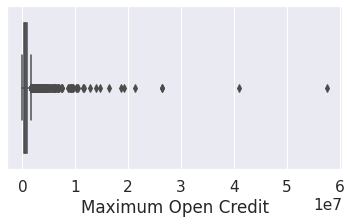

In [77]:
# Посомтрим на знаения, которые могут быть выбросами
plt.figure(figsize=(6, 3))

sns.boxplot(train_data['Maximum Open Credit'], whis=1.5)

plt.xlabel('Maximum Open Credit')
plt.show()

### 2.2.6 Признаки Number of Credit Problems (количество проблем с кредитом) 

In [78]:
train_data['Credit_problems_errors '] = 0

In [79]:
train_data['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

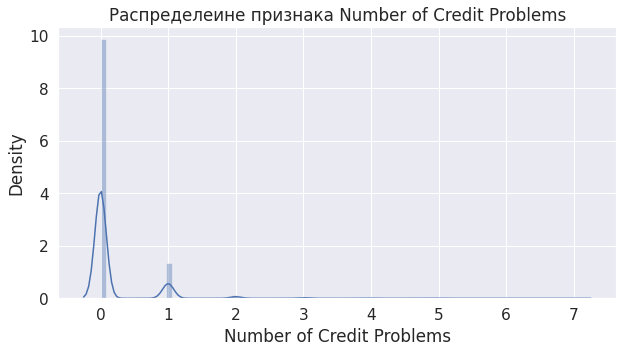

In [80]:
# Распределеине значений признакак Number of Credit Problems
plt.figure(figsize = (10, 5))

sns.distplot(train_data['Number of Credit Problems'], bins=80)
plt.title("Распределеине признака Number of Credit Problems")
plt.show()

In [81]:
train_data.loc[train_data['Number of Credit Problems'].isna() | \
               (train_data['Number of Credit Problems'] > 3), 'Credit_problems_errors'] = 1

In [82]:
train_data.loc[(train_data['Number of Credit Problems'].isna()) | \
               (train_data['Number of Credit Problems'] > 3), 'Number of Credit Problems'] = train_data['Number of Credit Problems'].median()

### 2.2.7 Months since last delinquent (количество месяцев с последней просрочки платежа)

In [83]:
train_data['Months since last delinquent'].value_counts()

14.0     76
29.0     71
33.0     68
8.0      68
19.0     65
         ..
84.0      1
86.0      1
91.0      1
118.0     1
92.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

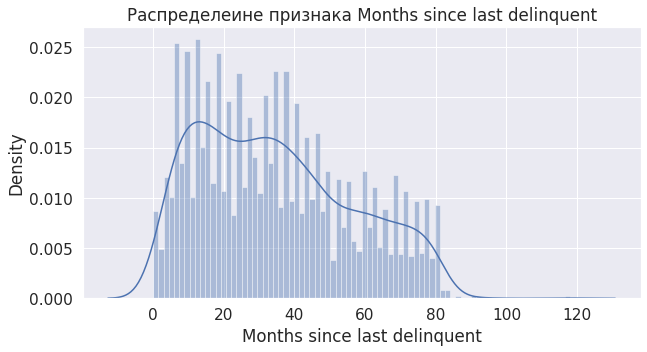

In [84]:
# Распределеине значений признакак Months since last delinquent
plt.figure(figsize = (10, 5))

sns.distplot(train_data['Months since last delinquent'], bins=80)
plt.title("Распределеине признака Months since last delinquent")
plt.show()

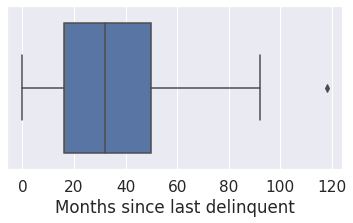

In [85]:
# Посомтрим на знаения, которые могут быть выбросами
plt.figure(figsize=(6, 3))

sns.boxplot(train_data['Months since last delinquent'], whis=1.5)

plt.xlabel('Months since last delinquent')
plt.show()

In [86]:
train_data['Months_last_delinquent_errors'] = 0

значения признака больше 83 считаем за выбросы. Делаем пометку в соответствующем признаке 

In [87]:
train_data.loc[(train_data['Months since last delinquent'].isna()) | \
               (train_data['Months since last delinquent'] > 83), 'Months_last_delinquent_errors'] = 1

train_data.loc[(train_data['Months since last delinquent'].isna()) | \
               (train_data['Months since last delinquent'] > 83), 'Months since last delinquent'] = train_data['Months since last delinquent'].median()

In [88]:
train_data['Months since last delinquent'].isna().sum()

0

### 2.2.7 Признак Bankruptcies (банкротство)

Выдвигаем следующие гипотезы относильно данных:
- банкротство либо есть либо его нет, т.е. признак принимает значения 1 или 0



In [89]:
train_data['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

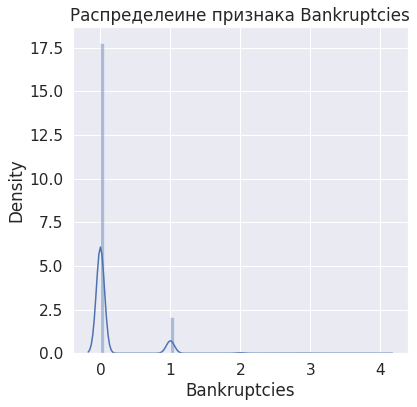

In [90]:
# Распределеине значений признакак Bankruptcies
plt.figure(figsize = (6, 6))

sns.distplot(train_data['Bankruptcies'], bins=80)
plt.title("Распределеине признака Bankruptcies")
plt.show()

In [91]:
train_data['Bankruptcies_errors'] = 0
train_data.loc[(train_data['Bankruptcies'].isna()) | (train_data['Bankruptcies'] > 1), 'Bankruptcies_errors'] = 1
train_data.loc[(train_data['Bankruptcies'].isna()) | (train_data['Bankruptcies'] > 1), 'Bankruptcies'] = train_data['Bankruptcies'].median()

In [92]:
train_data['Bankruptcies'].isna().sum()

0

### 2.2.8 Признак Current Loan Amount (текущая сумма кредита)

Под данным признаком будем понимать остаток по кредиту.

- обработаем выбросы

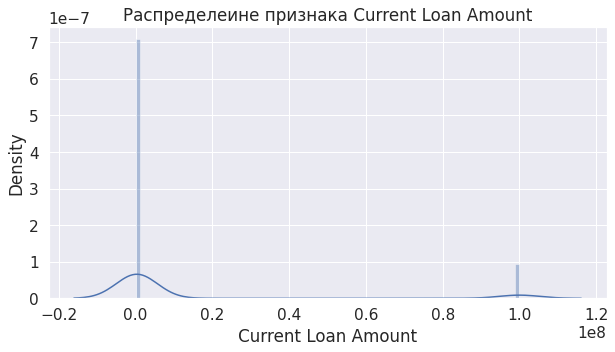

In [93]:
# Распределеине значений признакак Current Loan Amount
plt.figure(figsize = (10, 5))

sns.distplot(train_data['Current Loan Amount'], bins=80)
plt.title("Распределеине признака Current Loan Amount")
plt.show()

In [94]:
train_data[train_data['Current Loan Amount'] >= np.quantile(train_data['Current Loan Amount'], q=0.95)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term_Long Term,Term_Short Term,Annual_Income_error,Number_of_open_accounts_error,Years_of_credit_history_error,Maximum_open_credit_error,Credit_problems_errors,Credit_problems_errors,Months_last_delinquent_errors,Bankruptcies_errors
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,...,0,1,0,0,0,0,0,NaN,1,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,...,0,1,0,0,0,0,0,NaN,1,0
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,...,0,1,0,0,0,0,0,NaN,0,0
22,Rent,463790.0,10+ years,0.0,6.0,28.3,288442.0,0.0,32.0,0.0,...,0,1,0,0,0,0,0,NaN,1,0
27,Rent,1004055.0,8 years,0.0,7.0,14.5,328394.0,0.0,32.0,0.0,...,0,1,0,0,0,0,0,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7441,Rent,1406836.0,1 year,0.0,12.0,22.6,2383260.0,0.0,32.0,0.0,...,0,1,0,0,0,0,0,NaN,1,0
7445,Home Mortgage,1564384.0,6 years,0.0,21.0,17.3,1545016.0,0.0,32.0,0.0,...,1,0,0,0,0,0,0,NaN,1,0
7464,Home Mortgage,1159152.0,6 years,0.0,14.0,22.0,389356.0,1.0,77.0,1.0,...,0,1,0,0,0,0,0,NaN,0,0
7475,Rent,848426.0,10+ years,0.0,8.0,20.1,526306.0,0.0,12.0,0.0,...,0,1,0,0,0,0,0,NaN,0,0


In [95]:
train_data['Current_loan_amount_error'] = 0
train_data.loc[train_data['Current Loan Amount'].isna() | \
               (train_data['Current Loan Amount'] >= np.quantile(train_data['Current Loan Amount'], q=0.95)), 'Current_loan_amount_error'] = 1
train_data.loc[train_data['Current Loan Amount'].isna() | \
               (train_data['Current Loan Amount'] >= np.quantile(train_data['Current Loan Amount'], q=0.95)), 'Current Loan Amount'] = \
train_data['Current Loan Amount'].median()

In [96]:
train_data['Current Loan Amount'].isna().sum()

0

### 2.2.9 Признак Current Credit Balance (текущий кредитный баланс)

Под данным признаком понимается сколько уже было уплачено заемщиком банку по кредитным обязательствам

- обработаем выбросы

In [97]:
train_data['credit_balance_error'] = 0

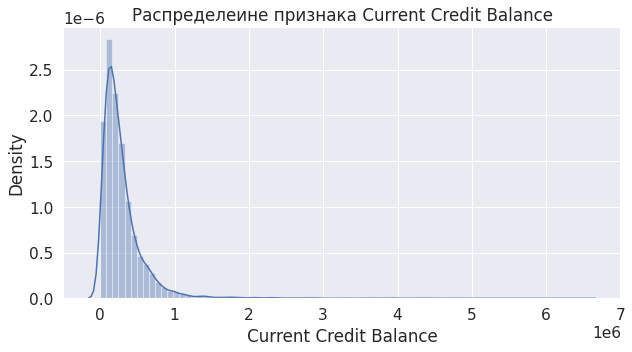

In [98]:
# Распределеине значений признакак Current Credit Balance
plt.figure(figsize = (10, 5))

sns.distplot(train_data['Current Credit Balance'], bins=80)
plt.title("Распределеине признака Current Credit Balance")
plt.show()

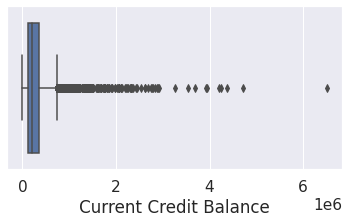

In [99]:
# Посомтрим на знаения, которые могут быть выбросами
plt.figure(figsize=(6, 3))

sns.boxplot(train_data['Current Credit Balance'], whis=1.5)

plt.xlabel('Current Credit Balance')
plt.show()

In [100]:
train_data[train_data['Current Credit Balance'] >= np.quantile(train_data['Current Credit Balance'], q=0.95)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Annual_Income_error,Number_of_open_accounts_error,Years_of_credit_history_error,Maximum_open_credit_error,Credit_problems_errors,Credit_problems_errors,Months_last_delinquent_errors,Bankruptcies_errors,Current_loan_amount_error,credit_balance_error
13,Rent,2066364.0,10+ years,0.0,11.0,17.7,1654026.0,0.0,32.0,0.0,...,0,0,0,0,0,NaN,1,0,0,0
14,Own Home,2258796.0,7 years,0.0,11.0,17.7,1602546.0,0.0,32.0,0.0,...,0,0,0,0,0,NaN,1,0,0,0
24,Own Home,1168386.0,10+ years,0.0,12.0,25.0,1216336.0,0.0,61.0,0.0,...,1,0,0,0,0,NaN,0,0,0,0
25,Rent,1353142.0,10+ years,0.0,3.0,29.8,1231912.0,0.0,32.0,0.0,...,0,0,0,0,0,NaN,1,0,0,0
74,Home Mortgage,1435127.0,< 1 year,0.0,10.0,21.2,1643906.0,0.0,68.0,0.0,...,0,0,0,0,0,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7404,Home Mortgage,1168386.0,10+ years,0.0,21.0,16.2,2468026.0,0.0,32.0,0.0,...,1,0,0,0,0,NaN,1,0,0,0
7412,Home Mortgage,1454013.0,10+ years,0.0,16.0,27.6,1854732.0,0.0,32.0,0.0,...,0,0,0,0,0,NaN,1,0,0,0
7445,Home Mortgage,1564384.0,6 years,0.0,21.0,17.3,1545016.0,0.0,32.0,0.0,...,0,0,0,0,0,NaN,1,0,1,0
7459,Home Mortgage,1168386.0,9 years,3.0,21.0,12.1,1547854.0,3.0,37.0,0.0,...,1,0,0,0,0,NaN,0,0,0,0


In [101]:
train_data.loc[train_data['Current Credit Balance'].isna() | \
               (train_data['Current Credit Balance'] >= np.quantile(train_data['Current Credit Balance'], q=0.95)), 'credit_balance_error'] = 1

In [102]:
train_data.loc[train_data['Current Credit Balance'].isna() | \
               train_data['Current Credit Balance'] >= np.quantile(train_data['Current Credit Balance'], q=0.95), 'Current Credit Balance'] = \
train_data['Current Credit Balance'].median()

In [103]:
train_data['Current Credit Balance'].isna().sum()

0

### 2.2.10 Признак Monthly Debt (ежемесячный платеж)

- ежемесячный платеж по кредиту не может быть больше половины месячного заработка
- обработать выбросы

невыполнение исходных условий фиксируем в новойм признаке monthly_debt_error

In [104]:
train_data['monthly_debt_error'] = 0

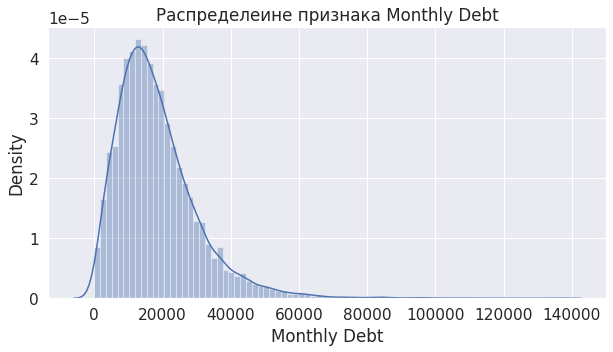

In [105]:
# Распределеине значений признакак Monthly Debt
plt.figure(figsize = (10, 5))

sns.distplot(train_data['Monthly Debt'], bins=80)
plt.title("Распределеине признака Monthly Debt")
plt.show()

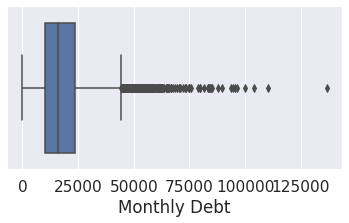

In [106]:
# Посомтрим на знаения, которые могут быть выбросами
plt.figure(figsize=(6, 3))

sns.boxplot(train_data['Monthly Debt'], whis=1.5)

plt.xlabel('Monthly Debt')
plt.show()

In [107]:
# #значения которые являются выбросами:
train_data[train_data['Monthly Debt'] > np.quantile(train_data['Monthly Debt'], q=0.95)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Number_of_open_accounts_error,Years_of_credit_history_error,Maximum_open_credit_error,Credit_problems_errors,Credit_problems_errors,Months_last_delinquent_errors,Bankruptcies_errors,Current_loan_amount_error,credit_balance_error,monthly_debt_error
14,Own Home,2258796.0,7 years,0.0,11.0,17.7,1602546.0,0.0,32.0,0.0,...,0,0,0,0,NaN,1,0,0,1,0
17,Home Mortgage,3361898.0,3 years,0.0,14.0,28.5,1042096.0,0.0,32.0,0.0,...,0,0,0,0,NaN,1,0,0,0,0
83,Rent,1860290.0,3 years,0.0,18.0,16.4,1120218.0,0.0,32.0,0.0,...,0,0,0,0,NaN,1,0,0,0,0
84,Home Mortgage,2539103.0,6 years,0.0,13.0,17.2,1211430.0,0.0,32.0,0.0,...,0,0,0,0,NaN,1,0,0,0,0
93,Home Mortgage,1168386.0,10+ years,0.0,18.0,17.9,3028014.0,0.0,32.0,0.0,...,0,0,0,0,NaN,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7454,Home Mortgage,1901520.0,8 years,0.0,12.0,10.5,297242.0,0.0,29.0,0.0,...,0,0,0,0,NaN,0,0,0,0,0
7459,Home Mortgage,1168386.0,9 years,3.0,21.0,12.1,1547854.0,3.0,37.0,0.0,...,0,0,0,0,NaN,0,0,0,1,0
7478,Home Mortgage,3888160.0,6 years,0.0,10.0,16.3,1435456.0,0.0,21.0,0.0,...,1,0,0,0,NaN,0,0,0,0,0
7485,Rent,2687664.0,< 1 year,0.0,14.0,16.7,429154.0,0.0,77.0,0.0,...,0,0,0,0,NaN,0,0,0,0,0


In [108]:
train_data.loc[(train_data['Monthly Debt'].isna() | \
                (train_data['Monthly Debt'] > np.quantile(train_data['Monthly Debt'], q=0.95)) | \
                ((train_data['Monthly Debt']/(train_data['Annual Income']/12))>=0.5)), 'monthly_debt_error'] = 1

In [109]:
train_data.loc[(train_data['Monthly Debt'].isna() | \
                (train_data['Monthly Debt'] > np.quantile(train_data['Monthly Debt'], q=0.95)) | \
                ((train_data['Monthly Debt']/(train_data['Annual Income']/12))>=0.5)), 'Monthly Debt'] = 1

### 2.2.11 Признак Credit Score (кредитный рейтинг)

In [110]:
#пометим пропуски
train_data['Creditscore_error'] = 0
train_data.loc[train_data['Credit Score'].isna(), 'Creditscore_error'] = 1

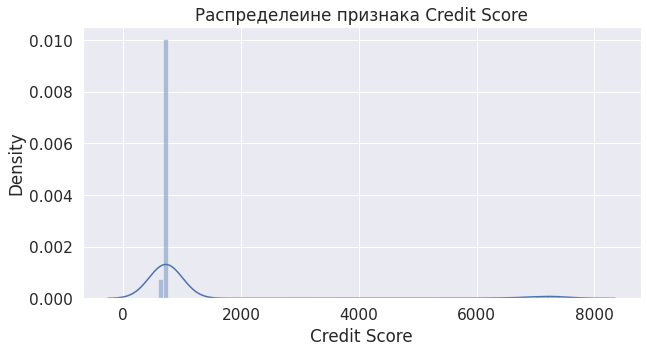

In [111]:
# Распределеине значений признакак Credit Score
plt.figure(figsize = (10, 5))

sns.distplot(train_data['Credit Score'], bins=80)
plt.title("Распределеине признака Credit Score")
plt.show()

In [112]:
base_feature_names

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [113]:
FEATURE_NAMES_Credit_Score = ['Home Ownership',
                             'Annual Income',
                             'Years in current job',
                             'Tax Liens',
                             'Number of Open Accounts',
                             'Years of Credit History',
                             'Maximum Open Credit',
                             'Number of Credit Problems',
                             'Months since last delinquent',
                             'Bankruptcies',
                             'Purpose',
                             'Term',
                             'Current Loan Amount',
                             'Current Credit Balance',
                             'Monthly Debt']

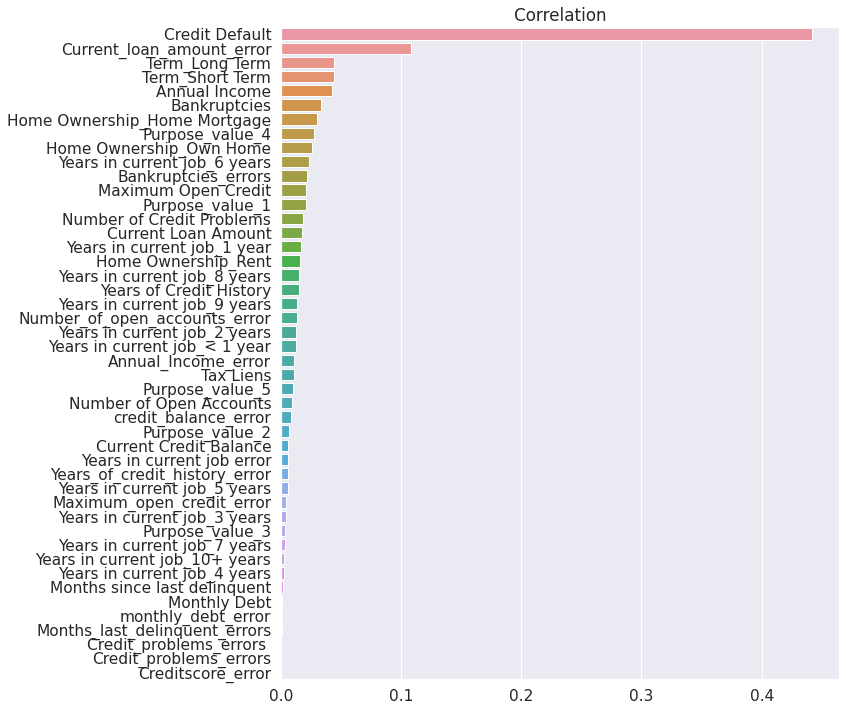

In [114]:
FEATURE_NAMES_Credit_Score = train_data.columns.drop(['Credit Score']+['Id']).tolist()
corr_Credit_Score = train_data[FEATURE_NAMES_Credit_Score + ['Credit Score']].corr().iloc[:-1, -1]
corr_Credit_Score = np.abs(corr_Credit_Score).sort_values(ascending=False)

plt.figure(figsize=(10, 12))

sns.barplot(x=corr_Credit_Score.values, y=corr_Credit_Score.index)

plt.title('Correlation')
plt.show()

In [115]:
TARGET_FEATURE = corr_Credit_Score[:20].index.tolist()
TARGET_FEATURE

['Credit Default',
 'Current_loan_amount_error',
 'Term_Long Term',
 'Term_Short Term',
 'Annual Income',
 'Bankruptcies',
 'Home Ownership_Home Mortgage',
 'Purpose_value_4',
 'Home Ownership_Own Home',
 'Years in current job_6 years',
 'Bankruptcies_errors',
 'Maximum Open Credit',
 'Purpose_value_1',
 'Number of Credit Problems',
 'Current Loan Amount',
 'Years in current job_1 year',
 'Home Ownership_Rent',
 'Years in current job_8 years',
 'Years of Credit History',
 'Years in current job_9 years']

In [116]:
data = train_data.loc[(train_data['Credit Score'].notnull()), FEATURE_NAMES_Credit_Score + ['Credit Score']]

In [117]:
%%time

# учимся на Регрессии

model_Credit_Score = LogisticRegression()
model_Credit_Score.fit(data[TARGET_FEATURE], data['Credit Score'])

NameError: name 'LogisticRegression' is not defined

In [118]:
train_data.loc[(train_data['Credit Score'].isnull()), ['Credit Score']] =\
model_Credit_Score.predict(train_data.loc[(train_data['Credit Score'].isnull()), TARGET_FEATURE])

NameError: name 'model_Credit_Score' is not defined

In [119]:
train_data[train_data['Credit Score'] > np.quantile(train_data['Credit Score'], q=0.95)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Years_of_credit_history_error,Maximum_open_credit_error,Credit_problems_errors,Credit_problems_errors,Months_last_delinquent_errors,Bankruptcies_errors,Current_loan_amount_error,credit_balance_error,monthly_debt_error,Creditscore_error


In [120]:
train_data.loc[(train_data['Credit Score'] > np.quantile(train_data['Credit Score'], q=0.95)), 'Creditscore_error'] = 1
train_data.loc[(train_data['Credit Score'] > np.quantile(train_data['Credit Score'], q=0.95)), 'Credit Score'] = train_data['Credit Score'].median()

# 3. Обработка пропусков 

In [121]:
# Посмотрим на количество пропусков по всем датасете
train_data.isna().sum()

Home Ownership                       0
Annual Income                        0
Years in current job                 0
Tax Liens                            0
Number of Open Accounts              0
Years of Credit History              0
Maximum Open Credit                  0
Number of Credit Problems            0
Months since last delinquent         0
Bankruptcies                         0
Purpose                              0
Term                                 0
Current Loan Amount                  0
Current Credit Balance               0
Monthly Debt                         0
Credit Score                      1557
Credit Default                       0
Years in current job error           0
Id                                   0
Home Ownership_Home Mortgage         0
Home Ownership_Own Home              0
Home Ownership_Rent                  0
Years in current job_1 year          0
Years in current job_10+ years       0
Years in current job_2 years         0
Years in current job_3 ye

In [122]:
train_data = train_data.drop('Credit_problems_errors', axis=1)

In [123]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.mode=None
        self.df_norm=None
        

    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        # Расчет моды
        self.mode = X.mode()
  
 

    def transform(self, X):
        """Трансформация данных"""


        # Home Ownership
        
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = "Home Mortgage"
        
        
        # Years in current job
        
        X['Years in current job error'] = 0
        X.loc[X['Years in current job'].isna(), 'Years in current job error'] = 1
        #заполнение пропусков
        X.loc[X['Years in current job'].isna(), 'Years in current job'] = self.mode['Years in current job'][0]

        
        # Purpose
        
        X.loc[X['Purpose'] == 'renewable energy', 'Purpose'] = 'other'

        def change_Purpose(X):
            X.loc[X['Purpose'].isin(['moving','major purchase','buy a car','vacation','home improvements','buy house']),'Purpose'] = 'value_1'
            X.loc[X['Purpose'].isin(['wedding','take a trip','debt consolidation']),'Purpose'] = 'value_2'
            X.loc[X['Purpose'].isin(['other','medical bills',]),'Purpose'] = 'value_3'
            X.loc[X['Purpose'].isin(['business loan', 'small business']),'Purpose'] = 'value_4'
            X.loc[X['Purpose'] == 'educational expenses', 'Purpose'] = 'value_5'
            return X

        X = change_Purpose(X)
        
#         #все категориальные переменные кодируем в dummy-признаки
#         for cat_colname in cat_feature_names:
#             X = pd.concat([X, pd.get_dummies(X[cat_colname], prefix=cat_colname)], axis=1)

        
        # Annual Income
        
        X['Annual_Income_error'] = 0
        X.loc[(X['Annual Income'].isna()) | (X['Annual Income'] > 8000000), 'Annual_Income_error'] = 1
        ##заменяем некорректные значения
        X.loc[(X['Annual Income'].isna()) | (X['Annual Income'] > 8000000), 'Annual Income'] = self.medians['Annual Income']
        

        # Number of Open Accounts
        
        X['Number_of_open_accounts_error'] = 0
        X.loc[(X['Number of Open Accounts'].isna()) | \
               (X['Number of Open Accounts'] > 22), 'Number_of_open_accounts_error'] = 1
        ##заменяем некорректные значения
        X.loc[(X['Number of Open Accounts'].isna()) | (X['Number of Open Accounts'] > 22), \
               'Number of Open Accounts'] = self.medians['Number of Open Accounts']
        
        
        # Years of Credit History
        
        X['Years_of_credit_history_error'] = 0 
        X.loc[(X['Years of Credit History'].isna()) | (X['Years of Credit History'] >= 52), 'Years_of_credit_history_error'] = 1
        ##заменяем некорректные значения
        X.loc[(X['Years of Credit History'].isna()) | (X['Years of Credit History'] > 52), 'Years of Credit History'] = self.medians['Years of Credit History']
        
        
        # Maximum Open Credit
        
        X['Maximum_open_credit_error'] = 0
        X.loc[(X['Maximum Open Credit'].isna()) | (X['Maximum Open Credit']>250000000), 'Maximum_open_credit_error'] = 1
        ##заменяем некорректные значения
        X.loc[(X['Maximum Open Credit'].isna()) | (X['Maximum Open Credit']>250000000), 'Maximum Open Credit'] = self.medians['Maximum Open Credit'] 
        

        # Number of Credit Problems
        
        X['Credit_problems_errors '] = 0

        X.loc[X['Number of Credit Problems'].isna() | \
               (X['Number of Credit Problems'] > 3), 'Credit_problems_errors'] = 1 
        X.loc[(X['Number of Credit Problems'].isna()) | \
               (X['Number of Credit Problems'] > 3), 'Number of Credit Problems'] = self.medians['Number of Credit Problems']
        X = X.drop('Credit_problems_errors', axis=1)

        
        # Months since last delinquent
        
        X['Months_last_delinquent_errors'] = 0
        X.loc[(X['Months since last delinquent'].isna()) | \
               (X['Months since last delinquent'] > 83), 'Months_last_delinquent_errors'] = 1
        ##заменяем некорректные значения
        X.loc[(X['Months since last delinquent'].isna()) | \
               (X['Months since last delinquent'] > 83), 'Months since last delinquent'] = self.medians['Months since last delinquent']


        # Bankruptcies
        
        X['Bankruptcies_errors'] = 0
        X.loc[(X['Bankruptcies'].isna()) | (X['Bankruptcies'] > 1), 'Bankruptcies_errors'] = 1
        ##заполнение пропусков
        X.loc[(X['Bankruptcies'].isna()) | (X['Bankruptcies'] > 1), 'Bankruptcies'] = self.medians['Bankruptcies']	
        

        # Current Loan Amount
         
        X['Current_loan_amount_error'] = 0
        X.loc[X['Current Loan Amount'].isna() | \
               (X['Current Loan Amount'] >= np.quantile(X['Current Loan Amount'], q=0.95)), 'Current_loan_amount_error'] = 1
        ##заменяем некорректные значения
        X.loc[X['Current Loan Amount'].isna() | \
               (X['Current Loan Amount'] >= np.quantile(X['Current Loan Amount'], q=0.95)), 'Current Loan Amount'] = \
        self.medians['Current Loan Amount']
        
    
        # Current Credit Balance
        
        X['credit_balance_error'] = 0
        X.loc[X['Current Credit Balance'].isna() | \
               (X['Current Credit Balance'] >= np.quantile(X['Current Credit Balance'], q=0.95)), 'credit_balance_error'] = 1
        ##заменяем некорректные значения
        X.loc[X['Current Credit Balance'].isna() | \
               X['Current Credit Balance'] >= np.quantile(X['Current Credit Balance'], q=0.95), 'Current Credit Balance'] = \
        X['Current Credit Balance'].median()
        
        
        # Monthly Debt
                 
        X['monthly_debt_error'] = 0
        X.loc[(X['Monthly Debt'].isna() | \
                (X['Monthly Debt'] > np.quantile(X['Monthly Debt'], q=0.95)) | \
                ((X['Monthly Debt']/(X['Annual Income']/12))>=0.5)), 'monthly_debt_error'] = 1
        ##заменяем некорректные значения
        X.loc[(X['Monthly Debt'].isna() | \
                (X['Monthly Debt'] > np.quantile(X['Monthly Debt'], q=0.95)) | \
                ((X['Monthly Debt']/(X['Annual Income']/12))>=0.5)), 'Monthly Debt'] = \
        self.medians['Monthly Debt']
        
        
#         # Credit Score
                 
        X['Credit_score_error'] = 0
#         X.loc[X['Credit Score'].isna(), 'Credit_score_error'] = 1
#         ## обучим модель для заполнения пропусков
#         FEATURE_NAMES_Credit_Score = ['Home Ownership',
#                                      'Annual Income',
#                                      'Years in current job',
#                                      'Tax Liens',
#                                      'Number of Open Accounts',
#                                      'Years of Credit History',
#                                      'Maximum Open Credit',
#                                      'Number of Credit Problems',
#                                      'Months since last delinquent',
#                                      'Bankruptcies',
#                                      'Purpose',
#                                      'Term',
#                                      'Current Loan Amount',
#                                      'Current Credit Balance',
#                                      'Monthly Debt']
 
#         TARGET_FEATURE = corr_Credit_Score[:20].index.tolist()

#         data = X.loc[(X['Credit Score'].notnull()), FEATURE_NAMES_Credit_Score + ['Credit Score']]

#         # учимся на Регрессии

#         model_Credit_Score = LogisticRegression()
#         model_Credit_Score.fit(data[TARGET_FEATURE], data['Credit Score'])

#         X.loc[(X['Credit Score'].isnull()), ['Credit Score']] =\
#         model_Credit_Score.predict(X.loc[(X['Credit Score'].isnull()), TARGET_FEATURE])
        ##заменяем некорректные значения
        X.loc[(train_data['Credit Score'] > np.quantile(X['Credit Score'], q=0.95)), 'Credit_score_error'] = 1
        X.loc[(train_data['Credit Score'] > np.quantile(X['Credit Score'], q=0.95)), 'Credit Score'] = X['Credit Score'].median()


        #если шде-то будут пропуски, будем заполнять их медианами
        X.fillna(self.medians, inplace=True)
               
        
        return X

# 4. Построение новых признаков

In [124]:
#сумма кредита
train_data['credit_sum'] = train_data['Current Loan Amount'] + train_data['Current Credit Balance']

In [125]:
#срок кредита в месяцах
train_data['credit_term'] = 0
def credit_term_function(X):
    X.loc[(X['Monthly Debt'] != 0), 'credit_term'] = X['credit_sum']/X['Monthly Debt']
    X.loc[(X['Monthly Debt'] == 0), 'credit_term'] = 0
    
    return X

call_credit_term_function = credit_term_function(train_data)

In [126]:
#сколько месяцев осталось платить кредит
train_data['balance_credit_term'] = 0
def balance_credit_term_function(X):
    X.loc[(X['Monthly Debt'] != 0), 'balance_credit_term'] = X['Current Loan Amount'] / X['Monthly Debt']
    X.loc[(X['Monthly Debt'] == 0), 'balance_credit_term'] = 0
    
    return X

call_balance_credit_term_function = balance_credit_term_function(train_data)

In [127]:
#коэффициент показывающий насколько процентов уплачен кредит
train_data['current_credit_coef'] = train_data['Current Credit Balance'] / train_data['credit_sum']

In [128]:
#коэффициент, показывающий сколько будет проблем с уплатой кредита за оставшийся срок кредита
train_data['problem_credit_coef'] = 0
def problem_credit_coef_function(X):
    X.loc[(X['Number of Credit Problems'] != 0), 'problem_credit_coef'] = X['Years of Credit History'] / \
    X['Number of Credit Problems'] * X['balance_credit_term']/12
    X.loc[(X['Number of Credit Problems'] == 0), 'problem_credit_coef'] = 0
    
    return X

call_problem_credit_coef_function = problem_credit_coef_function(train_data)

In [129]:
train_data.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Bankruptcies_errors,Current_loan_amount_error,credit_balance_error,monthly_debt_error,Creditscore_error,credit_sum,credit_term,balance_credit_term,current_credit_coef,problem_credit_coef
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,...,0,1,0,0,0,356959.0,45.104751,39.117134,0.132749,85.731719
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,...,0,0,0,0,0,659940.0,35.919012,14.421597,0.598497,0.000000
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,...,0,1,0,0,0,617962.0,45.268625,22.677679,0.499042,0.000000
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,...,0,0,0,0,0,217251.0,19.161316,10.707003,0.441218,20.075631
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,...,0,0,0,0,0,219149.0,30.522145,17.526462,0.425779,19.863324


### Опишем все изменения в новом классе:

In [130]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        
        self.credit_sum = None
        self.credit_term = None
        self.balance_credit_term = None
        self.current_credit_coef = None
        self.problem_credit_coef = None
        self.medians = None
        self.moda=None

        
    def fit(self, X, y=None):
        
        self.medians = X.median()
        self.mode = X.mode()
        X = X.copy()           
            
        
    def transform(self, X):
        
        #сумма кредита
        X['credit_sum'] = X['Current Loan Amount'] + X['Current Credit Balance']
        
        #срок кредита в месяцах
        X['credit_term'] = 0
        def credit_term_function(X):
            X.loc[(X['Monthly Debt'] != 0), 'credit_term'] = X['credit_sum']/X['Monthly Debt']
            X.loc[(X['Monthly Debt'] == 0), 'credit_term'] = 0

            return X

        call_credit_term_function = credit_term_function(X)
        
        #сколько месяцев осталось платить кредит
        X['balance_credit_term'] = 0
        def balance_credit_term_function(X):
            X.loc[(X['Monthly Debt'] != 0), 'balance_credit_term'] = X['Current Loan Amount'] / X['Monthly Debt']
            X.loc[(X['Monthly Debt'] == 0), 'balance_credit_term'] = 0

            return X

        call_balance_credit_term_function = balance_credit_term_function(X)

        #коэффициент показывающий насколько процентов уплачен кредит
        X['current_credit_coef'] = X['Current Credit Balance'] / X['credit_sum']
        
        #коэффициент, показывающий сколько будет проблем с уплатой кредита за оставшийся срок кредита
        X['problem_credit_coef'] = 0
        def problem_credit_coef_function(X):
            X.loc[(X['Number of Credit Problems'] != 0), 'problem_credit_coef'] = X['Years of Credit History'] / \
            X['Number of Credit Problems'] * X['balance_credit_term']/12
            X.loc[(X['Number of Credit Problems'] == 0), 'problem_credit_coef'] = 0

            return X

        call_problem_credit_coef_function = problem_credit_coef_function(X)
        
        
        #дамми переменные
        for cat_colname in X.select_dtypes(include='object').columns[1:]:
            X = pd.concat([X, pd.get_dummies(X[cat_colname], prefix=cat_colname)], axis=1)
            
            
        #перевод в категориальные перменные всех строковых
        for colname in cat_feature_names:
            X[colname] = pd.Categorical(X[colname])
        
        X.fillna(self.medians, inplace=True)
        
        return X

# 5. Разбиение на обучающую и тестовую выборки

In [131]:
train_data = pd.read_csv(TRAIN_DATASET_PATH)
test_data = pd.read_csv(TEST_DATASET_PATH)

In [132]:
train_data.shape, test_data.shape

((7500, 17), (2500, 16))

In [133]:
preprocessor = DataPreprocessing()
preprocessor.fit(train_data)

train_data = preprocessor.transform(train_data)
test_data = preprocessor.transform(test_data)

train_data.shape, test_data.shape

((7500, 29), (2500, 28))

In [134]:
features_gen = FeatureGenetator()
features_gen.fit(train_data)

train_data = features_gen.transform(train_data)
test_data = features_gen.transform(test_data)

train_data.shape, test_data.shape

((7500, 52), (2500, 51))

In [135]:
train_data.isna().sum().sum(),test_data.isna().sum().sum()

(0, 0)

In [136]:
# # _____________________________ 
# # замена выбросов на значения обученные с помощью случаного леса
# def imputer_rfr(data, target_col):
#     data = data.copy()
    
#     features = data.columns
    
#     data = data[features]
    
#     train = data[~data[target_col].isna()]
#     predict_data = data[data[target_col].isna()]

#     X = train.drop(columns=target_col)
#     y = train[target_col]
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                         test_size=0.2,
#                                                         shuffle=True,
#                                                         random_state=42,
#                                                         stratify=target_col)
# #     model = CatBoostRegressor(n_estimators=300,
# #                              max_depth=10)
    
#     model = RandomForestRegressor(n_estimators=300,
#                                   max_depth=15,
#                                   random_state=42,
#                                   verbose=1)
#     model.fit(X_train, y_train)
    
#     pred_train = model.predict(X_train)
#     pred_test = model.predict(X_test)
    
#     print(f"r2 на train: {r2_score(y_train, pred_train)}")
#     print(f"r2 на test: {r2_score(y_test, pred_test)}")
    

#     pred = model.predict(predict_data.drop(columns=target_col))

#     data.loc[data[target_col].isna(), target_col] = list(pred)
    
#     return model, data

In [137]:
# train_data_copy = train_data.copy()
# test_data_copy = test_data.copy()

In [138]:
# train_data_copy.isna().sum().sum(), test_data_copy.isna().sum().sum()

In [139]:
# def preprocess_outlier(X, col):
#     X.loc[X[col] > X[col].quantile(.975), col] = np.nan
#     X.loc[X[col] < X[col].quantile(.025), col] = np.nan
    
#     return X

# # feature_name = 'Credit Score'
# # train_data_copy = preprocess_outlier(train_data_copy, feature_name)
# # test_data_copy = preprocess_outlier(test_data_copy, feature_name)

# # train_data_copy[feature_name].isna().sum(), test_data_copy[feature_name].isna().sum(),

In [140]:
#новые фичи
new_feature_names = train_data.columns.drop(base_feature_names + ['Credit Default']).tolist()

In [141]:
new_num_feature_names = num_feature_names + new_feature_names
len(new_num_feature_names)

47

In [142]:
selected_features = new_num_feature_names + cat_feature_names

In [143]:
# from tqdm import tqdm

# for feature_name in tqdm(new_num_feature_names):
#     train_data_copy = preprocess_outlier(train_data_copy, feature_name)
#     bill_feature_predictor, train_data_copy = imputer_rfr(train_data_copy[new_num_feature_names], feature_name)
    
# #     test_data_copy = preprocess_outlier(test_data_copy, feature_name)
# #     bill_feature_predictor, test_data_copy = imputer_rfr(test_data_copy[new_num_feature_names], feature_name)

In [144]:
# train_data_copy.isna().sum(), #test_data_copy.isna().sum(),

In [145]:
# from sklearn.ensemble import RandomForestRegressor
# from catboost import CatBoostRegressor

In [146]:
# %%time

# bill_amt1_predictor, train_data_copy = imputer_rfr(train_data_copy[new_num_feature_names], feature_name)

### Стандартизация

In [147]:
scaler = StandardScaler()

train_data_norm = train_data.copy()
test_data_norm = test_data.copy()
train_data_norm[new_num_feature_names] = scaler.fit_transform(train_data_norm[new_num_feature_names])
test_data_norm[new_num_feature_names] = scaler.fit_transform(test_data_norm[new_num_feature_names])

train_data = train_data_norm.copy()
test_data = test_data_norm.copy()

### Разбиение на тренировочную и валидационную выборки

In [148]:
X = train_data[selected_features]
y = train_data[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.25,
                                                    random_state=21,
                                                    stratify=y)

In [149]:
df_for_balancing = pd.concat([X_train[new_num_feature_names], y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

0    4040
1    4040
Name: Credit Default, dtype: int64

In [150]:
X_train_balance = df_balanced.drop(columns=target_name)
y_train_balance = df_balanced[target_name]

## 6. Построение базовых моделей

In [151]:
#разбивать будем на 5 фолдов
cv=KFold(n_splits=5, random_state=21, shuffle=True)

### LR

In [152]:
# model_lr = LogisticRegression(C=25, 
#                               max_iter=100,
#                               penalty='l2',
#                               tol=0.001,
#                               random_state=21)
# model_lr.fit(X_train_balance, y_train_balance)

# y_train_pred = model_lr.predict(X_train_balance)
# y_test_pred = model_lr.predict(X_valid[new_num_feature_names])

# get_classification_report(y_train_balance, y_train_pred, y_valid, y_test_pred)

In [153]:
# lr_params = {'C': range(1,30,5),
#               'max_iter'range(5,100,10) }

In [154]:
# lr_grid = GridSearchCV(model_lr, 
#                        cv=cv,
#                        param_grid=lr_params)
# lr_grid.fit(X_train_balance, y_train_balance)
# GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
#              estimator=LogisticRegression(C=21, max_iter=10, random_state=21,
#                                           tol=0.001),
#              param_grid={'C': range(1, 30, 5), 'max_iter': [5, 10, 50, 60]})

In [155]:
# lr_grid.best_params_
# {'C': 21, 'max_iter': 10}

In [156]:
model_lr = LogisticRegression(C=21, 
                              max_iter=10,
                              penalty='l2',
                              tol=0.001,
                              random_state=21)
model_lr.fit(X_train_balance, y_train_balance)

y_train_pred = model_lr.predict(X_train_balance)
y_test_pred = model_lr.predict(X_valid[new_num_feature_names])

get_classification_report(y_train_balance, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.67      0.73      0.70      4040
           1       0.71      0.64      0.67      4040

    accuracy                           0.69      8080
   macro avg       0.69      0.69      0.69      8080
weighted avg       0.69      0.69      0.69      8080

TEST

              precision    recall  f1-score   support

           0       0.82      0.72      0.77      1347
           1       0.45      0.60      0.52       528

    accuracy                           0.68      1875
   macro avg       0.64      0.66      0.64      1875
weighted avg       0.72      0.68      0.69      1875

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 17)

### KNN

In [158]:
# model_knn = KNeighborsClassifier(n_neighbors=400,
#                                  weights = 'distance',
#                                  leaf_size=15,
#                                  p=2)
# model_knn.fit(X_train_balance, y_train_balance)

# y_train_pred = model_knn.predict(X_train_balance)
# y_test_pred = model_knn.predict(X_valid[new_num_feature_names])

# get_classification_report(y_train_balance, y_train_pred, y_valid, y_test_pred)

In [159]:
# knn_params = {'n_neighbors': range(100,2000,200),
#               'leaf_size': range(5,21,5)}

In [160]:
# knn_grid = GridSearchCV(model_knn,
#                         cv=cv,
#                         param_grid=knn_params)
# knn_grid.fit(X_train_balance, y_train_balance)
# GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
#              estimator=KNeighborsClassifier(leaf_size=15, n_neighbors=300,
#                                             weights='distance'),
#              param_grid={'leaf_size': range(5, 21, 5),
#                          'n_neighbors': range(100, 2000, 200)})

In [161]:
# knn_grid.best_params_
# {'leaf_size': 5, 'n_neighbors': 300}

In [162]:
model_knn = KNeighborsClassifier(n_neighbors=300,
                                 weights = 'distance',
                                 leaf_size=5,
                                 p=2)
model_knn.fit(X_train_balance, y_train_balance)

y_train_pred = model_knn.predict(X_train_balance)
y_test_pred = model_knn.predict(X_valid[new_num_feature_names])

get_classification_report(y_train_balance, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4040
           1       1.00      1.00      1.00      4040

    accuracy                           1.00      8080
   macro avg       1.00      1.00      1.00      8080
weighted avg       1.00      1.00      1.00      8080

TEST

              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1347
           1       0.45      0.60      0.51       528

    accuracy                           0.68      1875
   macro avg       0.63      0.65      0.63      1875
weighted avg       0.71      0.68      0.69      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               953  394
1               212  316


### RandomForest

In [163]:
# model_randomforest = RandomForestClassifier(max_depth=10, 
#                                             random_state=21,
#                                             n_estimators=2000,
#                                             min_samples_leaf=3,
#                                            ) 

# model_randomforest.fit(X_train_balance, y_train_balance)

# y_train_pred = model_randomforest.predict(X_train_balance)
# y_test_pred = model_randomforest.predict(X_valid[new_num_feature_names])

# get_classification_report(y_train_balance, y_train_pred, y_valid, y_test_pred)

# TRAIN

#               precision    recall  f1-score   support

#            0       0.82      0.84      0.83      4040
#            1       0.84      0.82      0.83      4040

#     accuracy                           0.83      8080
#    macro avg       0.83      0.83      0.83      8080
# weighted avg       0.83      0.83      0.83      8080

# TEST

#               precision    recall  f1-score   support

#            0       0.81      0.79      0.80      1347
#            1       0.49      0.52      0.51       528

#     accuracy                           0.71      1875
#    macro avg       0.65      0.65      0.65      1875
# weighted avg       0.72      0.71      0.71      1875

# CONFUSION MATRIX

# col_0              0    1
# Credit Default           
# 0               1058  289
# 1                252  276

In [164]:
# randomforest_params = {'max_depth': range(5,15,5),
#                        'max_features': range(1,3),
#                        'n_estimators': range(500,2000,500)}

In [165]:
# randomforest_grid = GridSearchCV(model_randomforest, 
#                                  randomforest_params,
#                                  cv=cv,
#                                  n_jobs=-1,
#                                  verbose=True)
# randomforest_grid.fit(X_train_balance, y_train_balance)
# вывод:
# Fitting 5 folds for each of 12 candidates, totalling 60 fits
# GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
#              estimator=RandomForestClassifier(max_depth=10, min_samples_leaf=3,
#                                               n_estimators=2000,
#                                               random_state=21),
#              n_jobs=-1,
#              param_grid={'max_depth': range(5, 15, 5),
#                          'max_features': range(1, 3),
#                          'n_estimators': range(500, 2000, 500)},
#              verbose=True)

In [166]:
# randomforest_grid.best_params_
# вывод:
# {'max_depth': 10, 'max_features': 2, 'n_estimators': 1000}

In [167]:
model_randomforest = RandomForestClassifier(max_depth=10, 
                                            random_state=21,
                                            n_estimators=500,
                                            min_samples_leaf=3,
                                            max_features=1)

model_randomforest.fit(X_train_balance, y_train_balance)

y_train_pred = model_randomforest.predict(X_train_balance)
y_test_pred = model_randomforest.predict(X_valid[new_num_feature_names])

get_classification_report(y_train_balance, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      4040
           1       0.81      0.79      0.80      4040

    accuracy                           0.81      8080
   macro avg       0.81      0.81      0.81      8080
weighted avg       0.81      0.81      0.81      8080

TEST

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1347
           1       0.49      0.54      0.51       528

    accuracy                           0.71      1875
   macro avg       0.65      0.66      0.65      1875
weighted avg       0.72      0.71      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1049  298
1                244  284


### LGBM

In [168]:
# model_lgbm = lgbm.LGBMClassifier(random_state=21,
#                                  num_leaves=30,
#                                  max_depth=50, 
#                                  n_estimators=300)
# model_lgbm.fit(X_train_balance, y_train_balance)

# y_train_pred = model_lgbm.predict(X_train_balance)
# y_test_pred = model_lgbm.predict(X_valid[new_num_feature_names])

# get_classification_report(y_train_balance, y_train_pred, y_valid, y_test_pred)

# TRAIN

#               precision    recall  f1-score   support

#            0       0.99      1.00      0.99      4040
#            1       1.00      0.99      0.99      4040

#     accuracy                           0.99      8080
#    macro avg       0.99      0.99      0.99      8080
# weighted avg       0.99      0.99      0.99      8080

# TEST

#               precision    recall  f1-score   support

#            0       0.79      0.89      0.83      1347
#            1       0.57      0.39      0.46       528

#     accuracy                           0.75      1875
#    macro avg       0.68      0.64      0.65      1875
# weighted avg       0.73      0.75      0.73      1875

# CONFUSION MATRIX

# col_0              0    1
# Credit Default           
# 0               1195  152
# 1                324  204

In [169]:
# lgbm_params = {'max_depth': range(10,50,10),
#                'n_estimators': range(500,2000,500),
#               }

In [170]:
# lgbm_grid = GridSearchCV(model_lgbm,
#                          lgbm_params,
#                          cv=cv,
#                          n_jobs=-1,
#                          verbose=True)
# lgbm_grid.fit(X_train_balance, y_train_balance)

In [171]:
# lgbm_grid.best_params_
# {'max_depth': 20, 'n_estimators': 1500}

In [172]:
model_lgbm = lgbm.LGBMClassifier(random_state=21,
                                 num_leaves=30,
                                 max_depth=20, 
                                 n_estimators=1500,
                                 max_features=2,
                                )
model_lgbm.fit(X_train_balance, y_train_balance)

y_train_pred = model_lgbm.predict(X_train_balance)
y_test_pred = model_lgbm.predict(X_valid[new_num_feature_names])

get_classification_report(y_train_balance, y_train_pred, y_valid, y_test_pred)

[LightGBM] [Warning] Unknown parameter: max_features
TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4040
           1       1.00      1.00      1.00      4040

    accuracy                           1.00      8080
   macro avg       1.00      1.00      1.00      8080
weighted avg       1.00      1.00      1.00      8080

TEST

              precision    recall  f1-score   support

           0       0.79      0.88      0.84      1347
           1       0.58      0.41      0.48       528

    accuracy                           0.75      1875
   macro avg       0.68      0.65      0.66      1875
weighted avg       0.73      0.75      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1190  157
1                313  215


### GradienBoosting

In [173]:
model_gb = GradientBoostingClassifier(criterion='mse',
                                      max_depth=7,
                                      min_samples_leaf=60,
                                      random_state=42,  
                                      n_estimators=800, 
                                      max_features='sqrt', 
                                      learning_rate=0.025)
model_gb.fit(X_train_balance, y_train_balance)

y_train_pred = model_gb.predict(X_train_balance)
y_test_pred = model_gb.predict(X_valid[new_num_feature_names])

get_classification_report(y_train_balance, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4040
           1       0.95      0.90      0.92      4040

    accuracy                           0.93      8080
   macro avg       0.93      0.93      0.93      8080
weighted avg       0.93      0.93      0.93      8080

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1347
           1       0.55      0.47      0.51       528

    accuracy                           0.74      1875
   macro avg       0.68      0.66      0.67      1875
weighted avg       0.73      0.74      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1148  199
1                282  246


In [174]:
# model_gb_params = {'max_depth': range(5,15,5),
#                    'n_estimators': range(500,2000,500),
#                    'min_samples_leaf': [25, 50,100]
#                   }

In [175]:
# gb_grid = GridSearchCV(model_gb,
#                        model_gb_params,
#                        cv=cv,
#                        n_jobs=-1,
#                        verbose=True)
# gb_grid.fit(X_train_balance, y_train_balance)

In [176]:
# gb_grid.best_params_
# {'max_depth': 10, 'min_samples_leaf': 25, 'n_estimators': 1500}

In [177]:
model_gb = GradientBoostingClassifier(criterion='mse',
                                      max_depth=10,
                                      min_samples_leaf=25,
                                      random_state=42,  
                                      n_estimators=1500, 
                                      max_features='sqrt', 
                                      learning_rate=0.025)
model_gb.fit(X_train_balance, y_train_balance)

y_train_pred = model_gb.predict(X_train_balance)
y_test_pred = model_gb.predict(X_valid[new_num_feature_names])

get_classification_report(y_train_balance, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4040
           1       1.00      1.00      1.00      4040

    accuracy                           1.00      8080
   macro avg       1.00      1.00      1.00      8080
weighted avg       1.00      1.00      1.00      8080

TEST

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1347
           1       0.57      0.41      0.48       528

    accuracy                           0.75      1875
   macro avg       0.68      0.64      0.65      1875
weighted avg       0.73      0.75      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1180  167
1                311  217


### CatBoost

In [178]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.548895899053628

In [179]:
# model_catb = catb.CatBoostClassifier(silent=True,
#                                      random_state=21,
#                                      n_estimators=1000,
#                                      max_depth=7,
#                                      learning_rate=0.1,
#                                      l2_leaf_reg=5,
# #                                      cat_features=cat_feature_names, 
# #                                      class_weights=[1, disbalance],
#                                      early_stopping_rounds=20,
#                                     )
# model_catb.fit(X_train_balance, y_train_balance)

# y_train_pred = model_catb.predict(X_train_balance)
# y_test_pred = model_catb.predict(X_valid[new_num_feature_names])

# get_classification_report(y_train_balance, y_train_pred, y_valid, y_test_pred)

In [180]:
# catb_params = {'n_estimators':range(600,1201,200),
#               'max_depth': [3,5,7,9],}

In [181]:
# catb_grid = GridSearchCV(model_catb, 
#                          catb_params,
#                          cv=cv,
#                          n_jobs=-1,
#                          verbose=True)
# catb_grid.fit(X_train_balance, y_train_balance)

In [182]:
# catb_grid.best_params_
# #вывод
# # {'max_depth': 7, 'n_estimators': 1200}

In [183]:
model_catb = catb.CatBoostClassifier(silent=True,
                                     random_state=21,
                                     n_estimators=1200,
                                     max_depth=7,
                                     learning_rate=0.1,
                                     l2_leaf_reg=5,
                                     early_stopping_rounds=20,
                                    )
model_catb.fit(X_train_balance, y_train_balance)

y_train_pred = model_catb.predict(X_train_balance)
y_test_pred = model_catb.predict(X_valid[new_num_feature_names])

get_classification_report(y_train_balance, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4040
           1       1.00      1.00      1.00      4040

    accuracy                           1.00      8080
   macro avg       1.00      1.00      1.00      8080
weighted avg       1.00      1.00      1.00      8080

TEST

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1347
           1       0.58      0.40      0.47       528

    accuracy                           0.75      1875
   macro avg       0.68      0.64      0.65      1875
weighted avg       0.73      0.75      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1194  153
1                318  210


### комбо моделей

In [184]:
from sklearn.ensemble import StackingClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier

model_lr = LogisticRegression(C=21, 
                              max_iter=10,
                              penalty='l2',
                              tol=0.001,
                              random_state=21,
                             )

model_knn = KNeighborsClassifier(n_neighbors=300,
                                 weights = 'distance',
                                 leaf_size=5,
                                 p=2,
                                )

model_rf = RandomForestClassifier(max_depth=10, 
                                  random_state=21,
                                  n_estimators=500,
                                  min_samples_leaf=3,
                                  max_features=1,
                                 )


model_gb = GradientBoostingClassifier(criterion='mse',
                                      max_depth=7,
                                      min_samples_leaf=60,
                                      random_state=42,  
                                      n_estimators=800, 
                                      max_features='sqrt', 
                                      learning_rate=0.025,
                                     )


final_model = StackingClassifier([('model_lr', model_lr), ('model_knn', model_knn), ('model_rf', model_rf)], \
                                final_estimator=model_gb)
final_model.fit(X_train_balance, y_train_balance)

NameError: name 'LogisticRegression' is not defined

In [185]:
y_train_pred = final_model.predict(X_train_balance)
y_test_pred = final_model.predict(X_valid[new_num_feature_names])

get_classification_report(y_train_balance, y_train_pred, y_valid, y_test_pred)

NameError: name 'final_model' is not defined

In [186]:
top_model = RandomForestClassifier(max_depth=10, 
                                     random_state=21,
                                     n_estimators=500,
                                     min_samples_leaf=3,
                                     max_features=1)

top_model.fit(X_train_balance, y_train_balance)

y_train_pred = top_model.predict(X_train_balance)
y_test_pred = top_model.predict(X_valid[new_num_feature_names])

get_classification_report(y_train_balance, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      4040
           1       0.81      0.79      0.80      4040

    accuracy                           0.81      8080
   macro avg       0.81      0.81      0.81      8080
weighted avg       0.81      0.81      0.81      8080

TEST

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1347
           1       0.49      0.54      0.51       528

    accuracy                           0.71      1875
   macro avg       0.65      0.66      0.65      1875
weighted avg       0.72      0.71      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1049  298
1                244  284


## Важность признаков

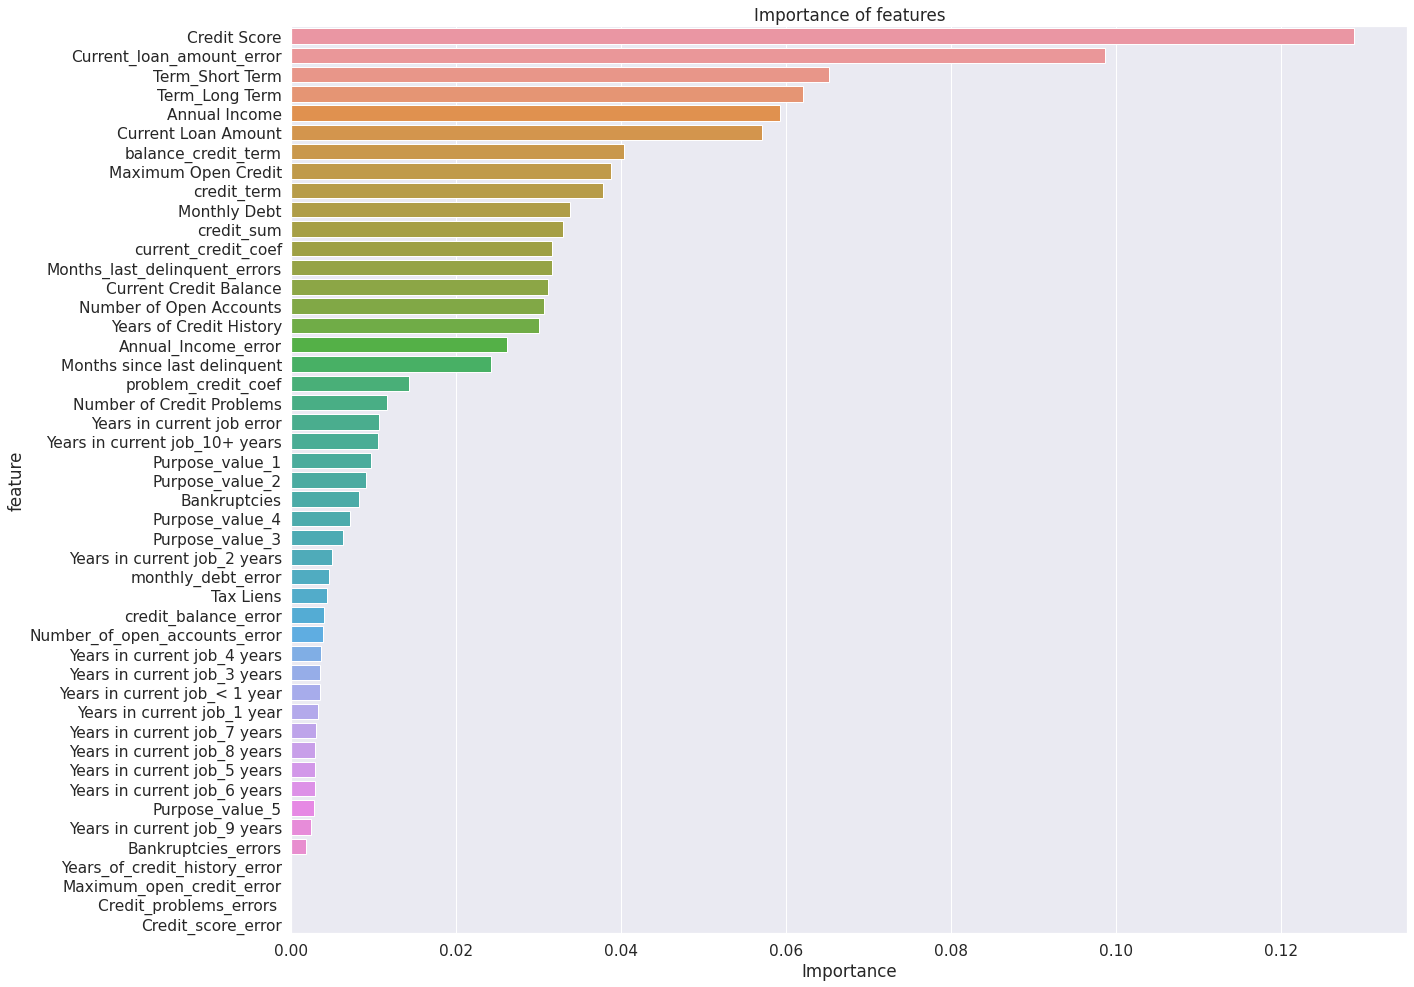

In [187]:
important_features_top = show_feature_importances(X_train_balance.columns,
                                                  top_model.feature_importances_, get_top=43)

In [188]:
important_features_top

['Credit Score',
 'Current_loan_amount_error',
 'Term_Short Term',
 'Term_Long Term',
 'Annual Income',
 'Current Loan Amount',
 'balance_credit_term',
 'Maximum Open Credit',
 'credit_term',
 'Monthly Debt',
 'credit_sum',
 'current_credit_coef',
 'Months_last_delinquent_errors',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Years of Credit History',
 'Annual_Income_error',
 'Months since last delinquent',
 'problem_credit_coef',
 'Number of Credit Problems',
 'Years in current job error',
 'Years in current job_10+ years',
 'Purpose_value_1',
 'Purpose_value_2',
 'Bankruptcies',
 'Purpose_value_4',
 'Purpose_value_3',
 'Years in current job_2 years',
 'monthly_debt_error',
 'Tax Liens',
 'credit_balance_error',
 'Number_of_open_accounts_error',
 'Years in current job_4 years',
 'Years in current job_3 years',
 'Years in current job_< 1 year',
 'Years in current job_1 year',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_5 years',
 

In [189]:
final_model = RandomForestClassifier(max_depth=10, 
                                     random_state=21,
                                     n_estimators=500,
                                     min_samples_leaf=3,
                                     max_features=1)

final_model.fit(X_train_balance[important_features_top], y_train_balance)

y_train_pred = final_model.predict(X_train_balance[important_features_top])
y_test_pred = final_model.predict(X_valid[important_features_top])

get_classification_report(y_train_balance, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      4040
           1       0.81      0.81      0.81      4040

    accuracy                           0.81      8080
   macro avg       0.81      0.81      0.81      8080
weighted avg       0.81      0.81      0.81      8080

TEST

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1347
           1       0.48      0.54      0.51       528

    accuracy                           0.71      1875
   macro avg       0.65      0.66      0.65      1875
weighted avg       0.72      0.71      0.71      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1038  309
1                242  286


## Сохранение финальной модели

In [190]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

# 7. Прогнозирование на тестовом датасете

In [191]:
test_data.shape

(2500, 51)

In [192]:
submit = pd.read_csv('../input/ds803/sample_submission.csv')
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [193]:
predictions = final_model.predict(test_data[important_features_top])
predictions

array([1, 0, 1, ..., 0, 1, 1])

In [194]:
submit['Credit Default'] = predictions
submit.head()

,Id,Credit Default
0,0,1
1,1,0
2,2,1
3,3,1
4,4,0


In [195]:
submit.to_csv('kos_teml.csv', index=False)